## Assignment: Image recognition
- Alumno 1: Adam Foldvari
- Alumno 2: Mate Lukacs
- Alumno 3: Joseph Tartivel

The goals of the assignment are:
* Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
* Put into practice the acquired knowledge to optimize the parameters and architecture of a feedforward Neural Net (ffNN), in the context of an image recognition problem.
* Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous task.
* Train popular architectures from scratch (e.g., GoogLeNet, VGG, ResNet, ...), and compare the results with the ones provided by their pre-trained versions using transfer learning.

Follow the link below to download the classification data set  “xview_recognition”: [https://drive.upm.es/s/4oNHlRFEd71HXp4](https://drive.upm.es/s/4oNHlRFEd71HXp4)

In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [4]:
categories = {0: 'Cargo plane', 1: 'Helicopter', 2: 'Small car', 3: 'Bus', 4: 'Truck', 5: 'Motorboat', 6: 'Fishing vessel', 7: 'Dump truck', 8: 'Excavator', 9: 'Building', 10: 'Storage tank', 11: 'Shipping container'}

In [5]:
import warnings
import rasterio
import numpy as np

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open('/kaggle/input/files/xview_recognition/'+filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    img = img / 255.0  # Normalize pixel values to [0,1]
    return img

#### Training
Design and train a ffNN to deal with the “xview_recognition” classification task.

In [6]:
import json

# Load database
json_file = '/kaggle/input/files/xview_recognition/xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [7]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)

{'Cargo plane': 635, 'Helicopter': 70, 'Small car': 4290, 'Bus': 2155, 'Truck': 2746, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 4689, 'Storage tank': 1469, 'Shipping container': 1523}


In [8]:
from sklearn.model_selection import train_test_split

anns_train, anns_valid = train_test_split(anns, test_size=0.1, random_state=1, shuffle=True)
print('Number of training images: ' + str(len(anns_train)))
print('Number of validation images: ' + str(len(anns_valid)))

Number of training images: 19239
Number of validation images: 2138


In [9]:
# Load architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, RandomFlip, RandomRotation, Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, RandomZoom, RandomContrast, RandomBrightness, RandomCrop, GaussianNoise
from tensorflow.keras.regularizers import l2


print('Load model')
model = Sequential()

# 1. Input Layer (explicitly define input tensor)
model.add(Input(shape=(224, 224, 3)))

# 2. Data Augmentation Layers
model.add(RandomFlip("horizontal_and_vertical"))
model.add(RandomRotation(0.2))  # 20% rotation
model.add(RandomZoom(0.2))        # Randomly zoom images by up to 20%
model.add(RandomContrast(0.2))   # Adjust image contrast randomly

# 3. Existing CNN Architecture
model.add(Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

# Add 3 more Conv-Pool block
model.add(Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(1024, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

# Flatten before dense layers
model.add(Flatten())

# Existing dense layers with batch normalization
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.6))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

# Output layer
model.add(Dense(len(categories), activation='softmax'))

model.summary()

Load model


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast (RandomContrast)     │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 14, 14, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 512)           │              

 Total params: 11,184,716 (42.67 MB)

 Trainable params: 11,178,892 (42.64 MB)

 Non-trainable params: 5,824 (22.75 KB)

In [10]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

def custom_lr_schedule(epoch):
    base_lr = 1e-3
    warmup_epochs = 5
    
    if epoch < warmup_epochs:
        return base_lr * (epoch + 1) / warmup_epochs
    
    if epoch % 20 == 0 and epoch != 0:
        return base_lr * 0.5
    
    return base_lr * (0.95 ** epoch)

opt = Adam(
   learning_rate=custom_lr_schedule(0),
   beta_1=0.9,
   epsilon=1e-7,
   clipnorm=1.0)

model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
lr_callback = LearningRateScheduler(custom_lr_schedule, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, restore_best_weights=True, mode='max')
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, lr_callback, early_stop, terminate]

In [12]:
def generator_images(objs, batch_size, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                images.append(load_geoimage(filename))
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            # Force channels-last format
            images = np.transpose(images, (0, 1, 2, 3))  # Swap width/channel axes
            yield images, labels

In [13]:
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]
# Generators
batch_size = 64
train_generator = generator_images(objs_train, batch_size, do_shuffle=True)
valid_generator = generator_images(objs_valid, batch_size, do_shuffle=False)

In [14]:
import math
import numpy as np

print('Training model')
epochs = 80
train_steps = math.ceil(len(objs_train)/batch_size)
valid_steps = math.ceil(len(objs_valid)/batch_size)

# Pass class_weights to model.fit()
h = model.fit(train_generator, steps_per_epoch=train_steps,
              validation_data=valid_generator, validation_steps=valid_steps,
              epochs=epochs, callbacks=callbacks, verbose=1)

best_idx = int(np.argmax(h.history['val_accuracy']))
best_value = np.max(h.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Training model

Epoch 1: LearningRateScheduler setting learning rate to 0.0002.
Epoch 1/80
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2216 - loss: 2.5403
Epoch 1: val_accuracy improved from -inf to 0.13985, saving model to model.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 798s 3s/step - accuracy: 0.2219 - loss: 2.5395 - val_accuracy: 0.1399 - val_loss: 2.7698 - learning_rate: 2.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0004.
Epoch 2/80
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.4031 - loss: 1.9352
Epoch 2: val_accuracy improved from 0.13985 to 0.49906, saving model to model.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 110s 365ms/step - accuracy: 0.4032 - loss: 1.9350 - val_accuracy: 0.4991 - val_loss: 1.5864 - learning_rate: 4.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0006000000000000001.
Epoch 3/80
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.4546 - loss: 1.7196
Epoch 3: val_accuracy did not improve from 0.49906
301

<ipython-input-15-b3401fe3e391>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


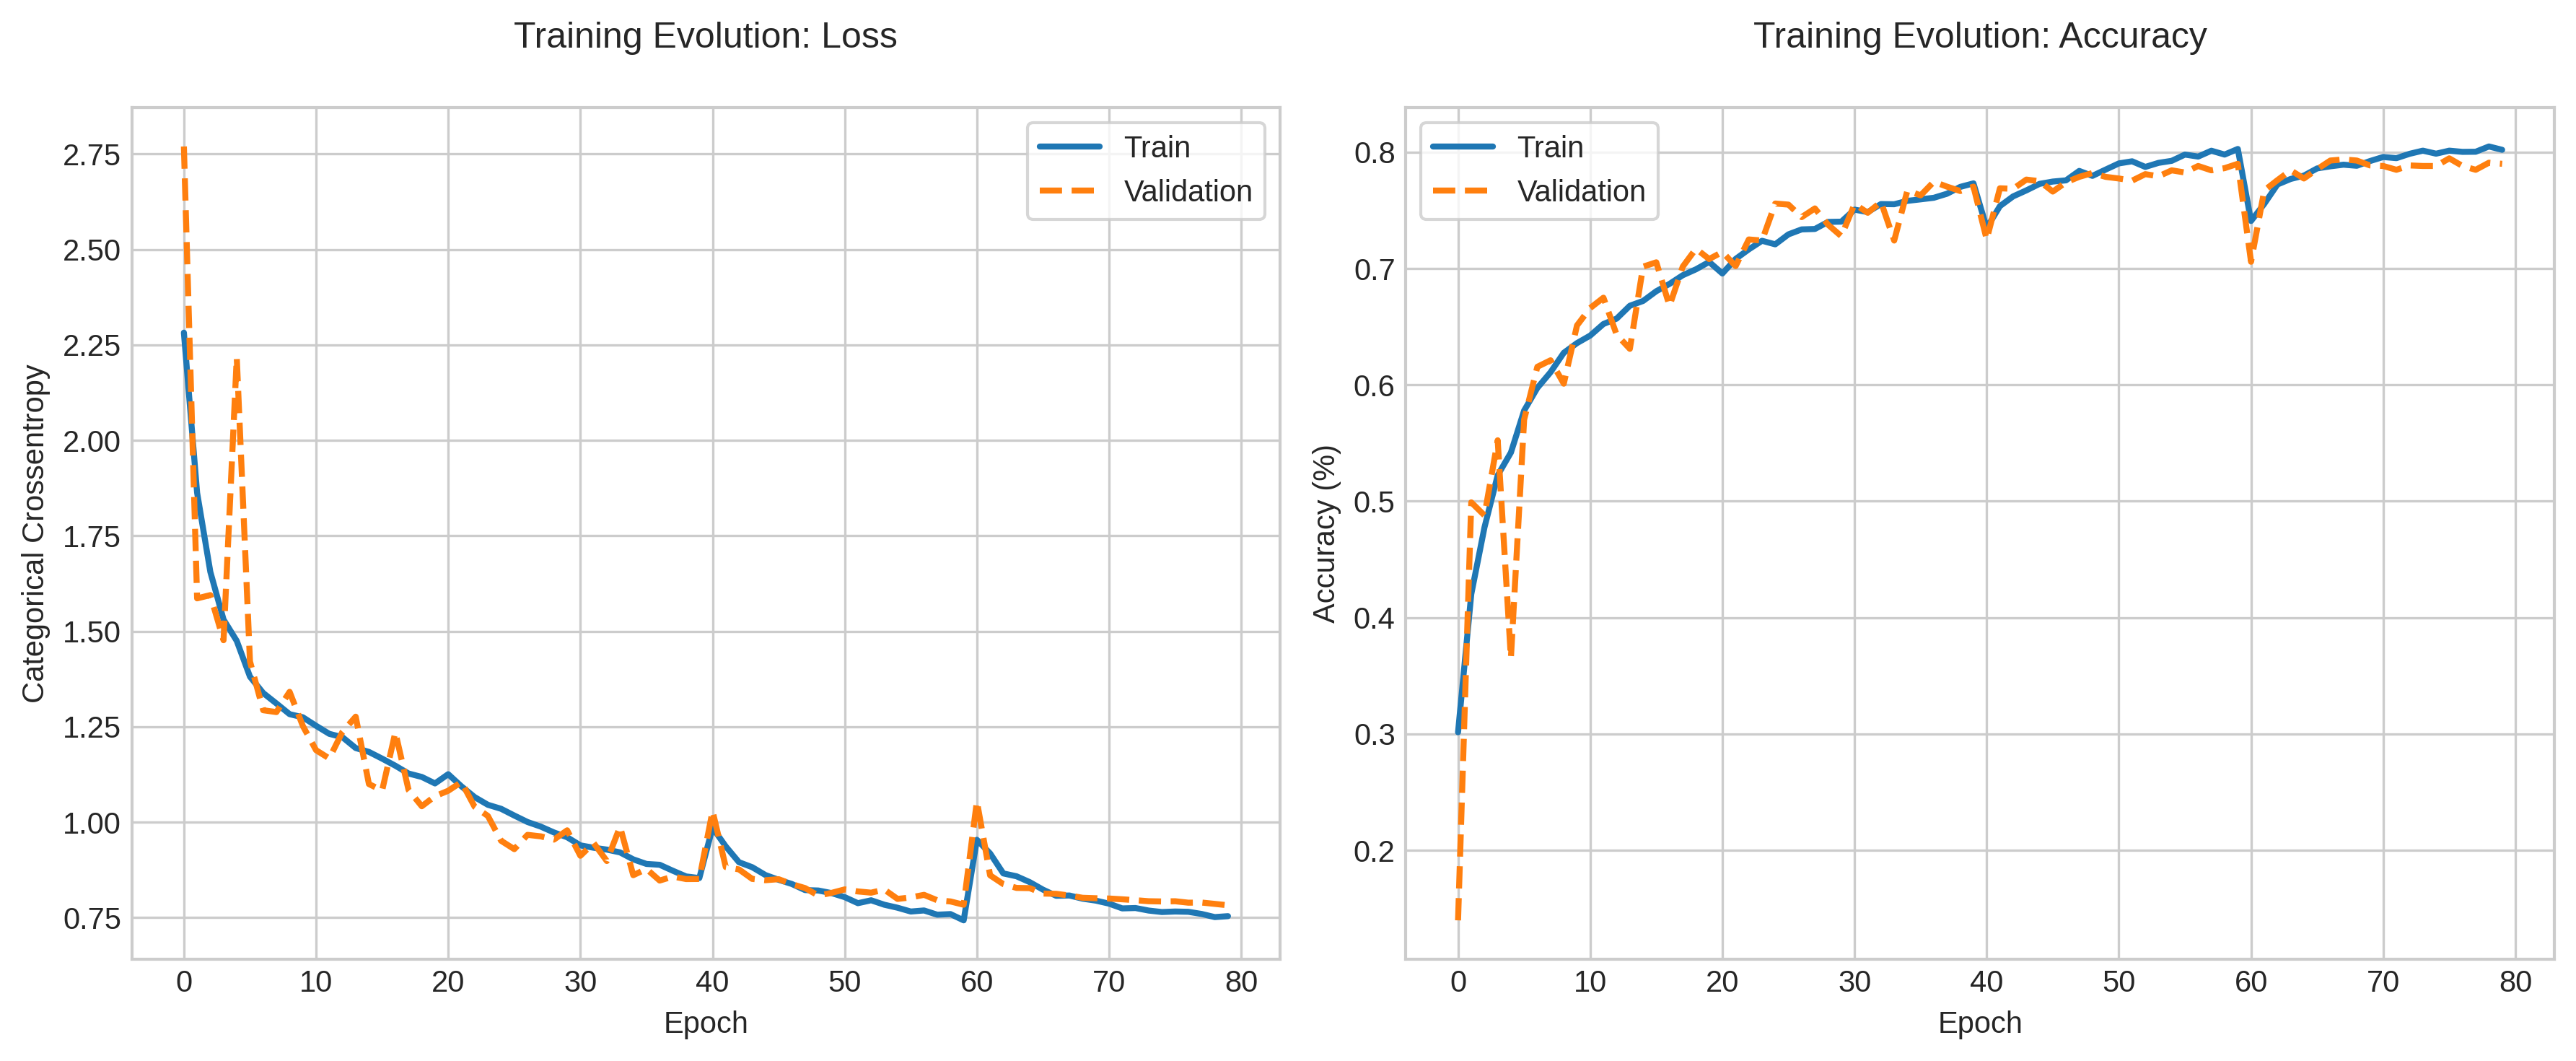

In [15]:
#PLOTS

import matplotlib.pyplot as plt

# Create subplots with custom styling
plt.figure(figsize=(12, 5), dpi=300)
plt.style.use('seaborn-whitegrid')

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'], color='#1f77b4', linewidth=2, label='Train')
plt.plot(h.history['val_loss'], color='#ff7f0e', linewidth=2, linestyle='--', label='Validation')
plt.title('Training Evolution: Loss', fontsize=12, pad=20)
plt.ylabel('Categorical Crossentropy', fontsize=10)
plt.xlabel('Epoch', fontsize=10)
plt.legend(frameon=True, facecolor='white')

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(h.history['accuracy'], color='#1f77b4', linewidth=2, label='Train')
plt.plot(h.history['val_accuracy'], color='#ff7f0e', linewidth=2, linestyle='--', label='Validation')
plt.title('Training Evolution: Accuracy', fontsize=12, pad=20)
plt.ylabel('Accuracy (%)', fontsize=10)
plt.xlabel('Epoch', fontsize=10)
plt.legend(frameon=True, facecolor='white')

plt.tight_layout()
plt.savefig('training_evolution.png', bbox_inches='tight', transparent=False)
plt.show()


#### Validation
Compute validation metrics.

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)

In [17]:
import numpy as np

model.load_weights('model.keras') #, by_name=True
y_true, y_pred = [], []
for ann in anns_valid:
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)

<ipython-input-16-39df9ea0fe34>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))


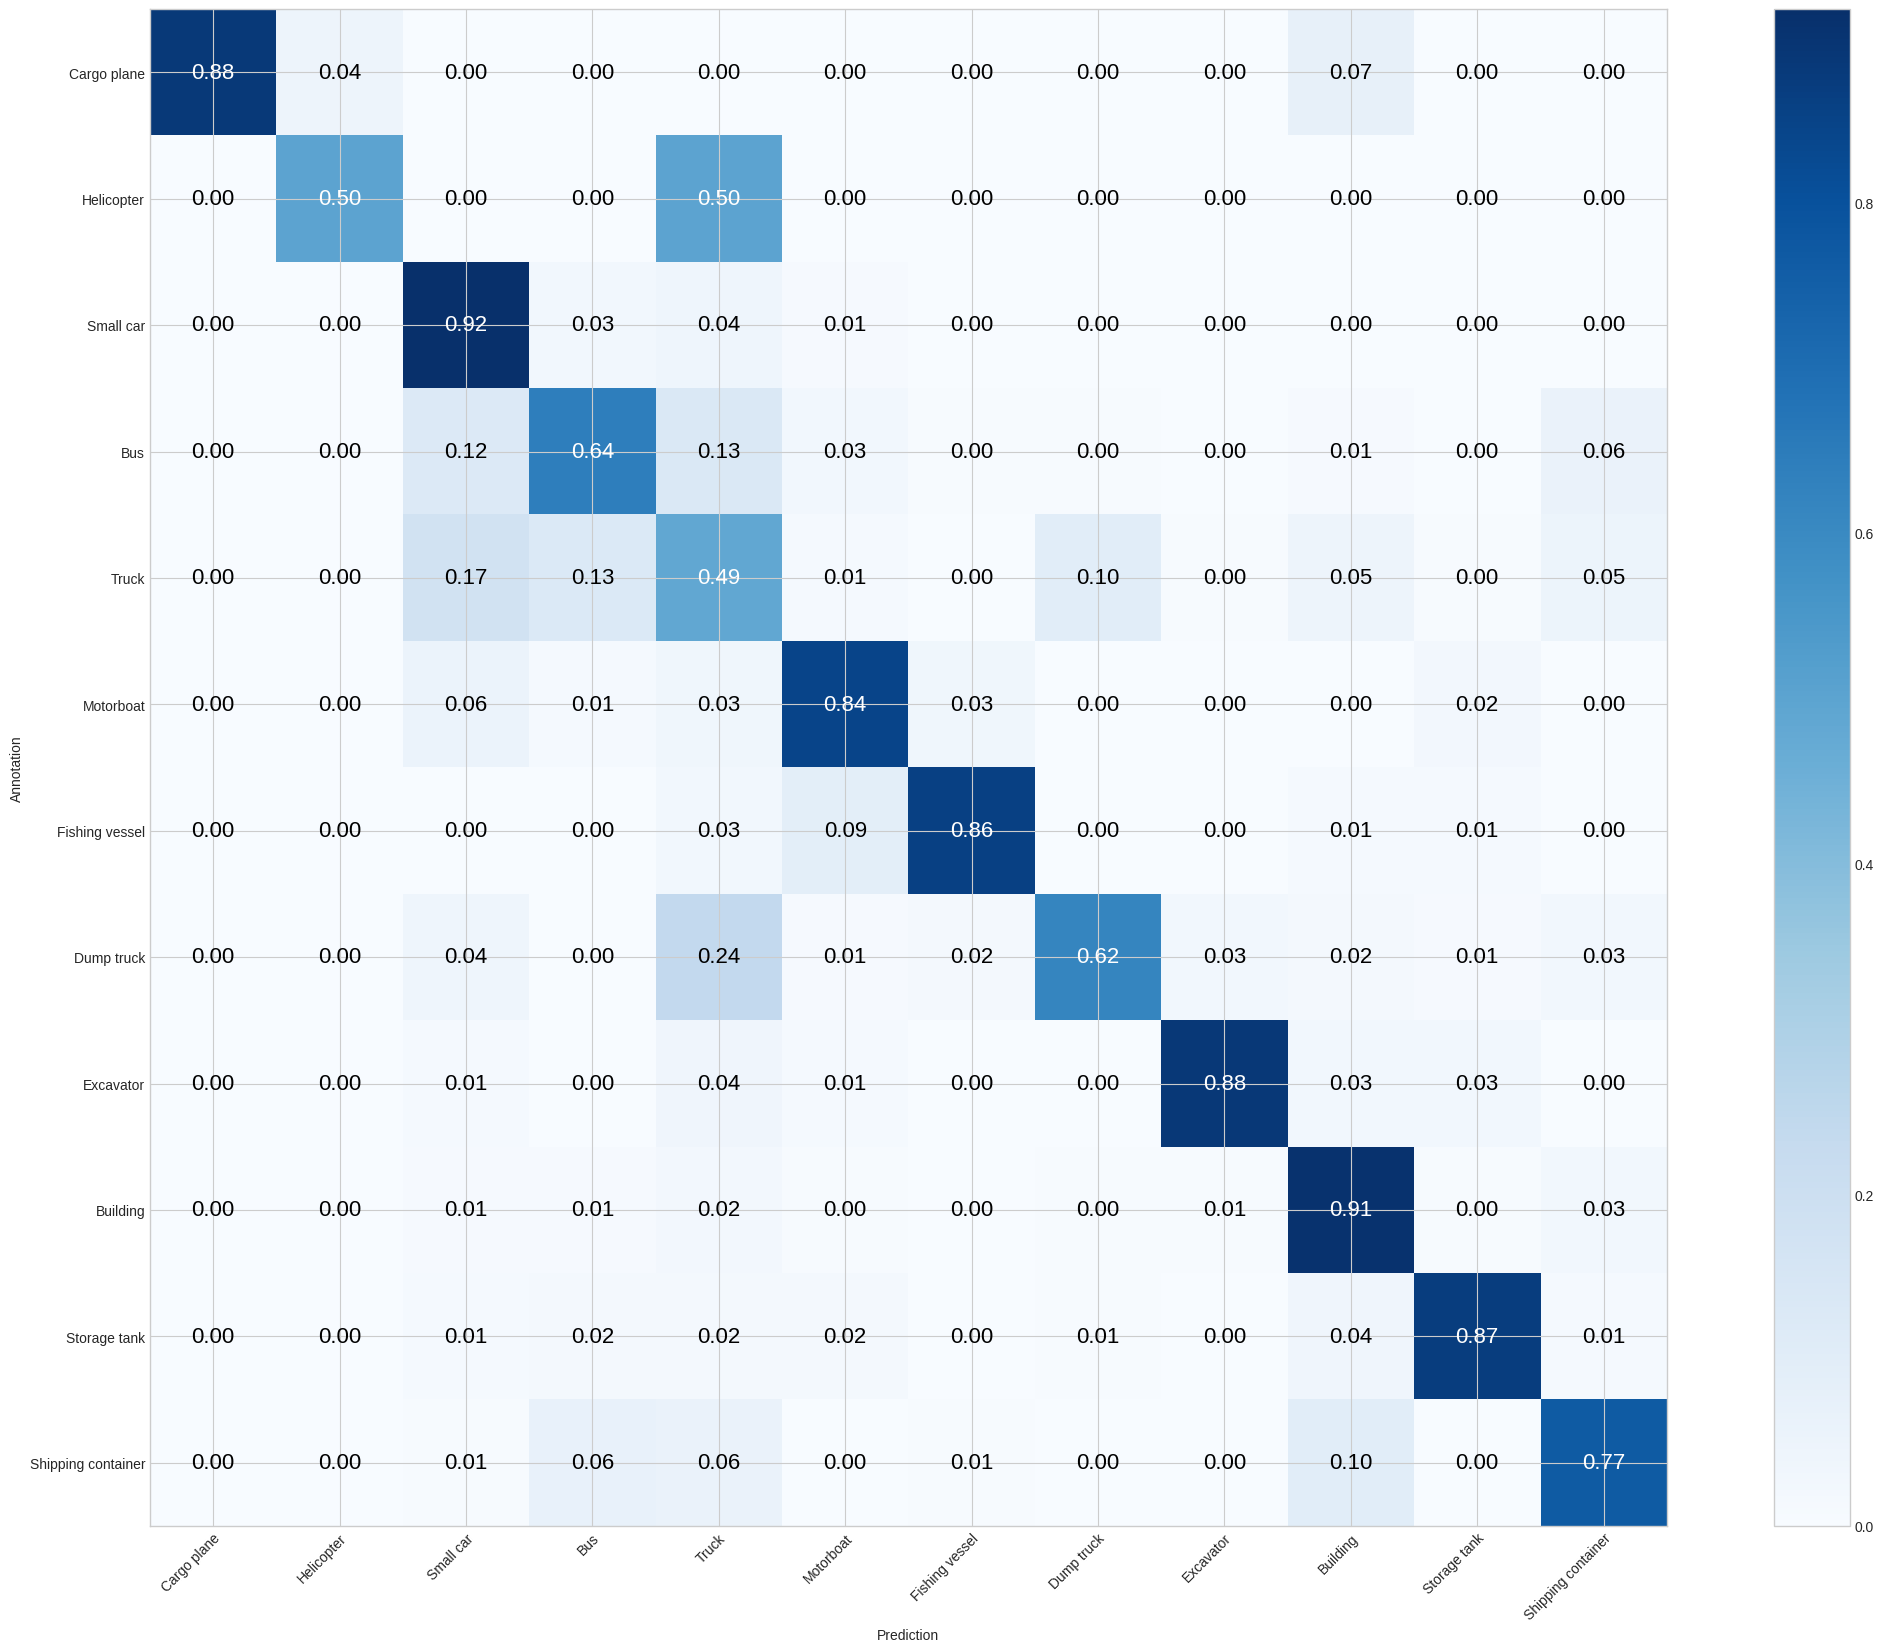

In [18]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [19]:
import numpy as np

# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 79.467%
Mean Recall: 76.414%
Mean Precision: 75.654%
> Cargo plane: Recall: 88.235% Precision: 98.361% Specificity: 99.952% Dice: 93.023%
> Helicopter: Recall: 50.000% Precision: 25.000% Specificity: 99.860% Dice: 33.333%
> Small car: Recall: 91.667% Precision: 80.882% Specificity: 94.703% Dice: 85.938%
> Bus: Recall: 63.927% Precision: 68.293% Specificity: 96.613% Dice: 66.038%
> Truck: Recall: 48.679% Precision: 54.661% Specificity: 94.287% Dice: 51.497%
> Motorboat: Recall: 84.270% Precision: 73.529% Specificity: 98.682% Dice: 78.534%
> Fishing vessel: Recall: 85.714% Precision: 89.189% Specificity: 99.612% Dice: 87.417%
> Dump truck: Recall: 61.538% Precision: 69.903% Specificity: 98.466% Dice: 65.455%
> Excavator: Recall: 88.462% Precision: 90.789% Specificity: 99.660% Dice: 89.610%
> Building: Recall: 90.927% Precision: 90.744% Specificity: 97.199% Dice: 90.836%
> Storage tank: Recall: 86.928% Precision: 93.662% Specificity: 99.547% Dice: 90.169%
> Shipping contain

#### Testing
Try to improve the results provided in the competition.

In [20]:
import os
import numpy as np

anns = []
for (dirpath, dirnames, filenames) in os.walk('/kaggle/input/files/xview_recognition/xview_test'):
    for filename in filenames:
        image = GenericImage(dirpath[18:]+'/'+filename)
        image.tile = np.array([0, 0, 224, 224])
        obj = GenericObject()
        obj.bb = (0, 0, 224, 224)
        obj.category = dirpath[dirpath.rfind('/')+1:]
        image.add_object(obj)
        anns.append(image)
print('Number of testing images: ' + str(len(anns)))

Number of testing images: 2635


In [21]:
import numpy as np

model.load_weights('model.keras') #, by_name=True
predictions_data = {"images": {}, "annotations": {}}
for idx, ann in enumerate(anns):
    file_name = ann.filename.split('/')[-1]
    image_data = {"image_id": file_name, "filename": file_name, "width": int(ann.tile[2]), "height": int(ann.tile[3])}
    predictions_data["images"][idx] = image_data
    # Load image
    image = load_geoimage('xview_test/' + file_name)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        annotation_data = {"image_id": ann.filename.split('/')[-1], "category_id": pred_category, "bbox": [int(x) for x in obj_pred.bb]}
        predictions_data["annotations"][idx] = annotation_data

In [22]:
with open("/kaggle/working/prediction_third.json", "w") as outfile:
    json.dump(predictions_data, outfile)